In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt

# 1. Import your custom engine tools
from data_loader import MarketDataLoader
from quant_math_engine import bates_call_price, implied_volatility

# 2. Load Data into RAM
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

print("✅ Base Data Loaded. Ready for Out-Of-Sample Testing.")

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
✅ Base Data Loaded. Ready for Out-Of-Sample Testing.


In [2]:
# --- 1. Define Dates ---
IN_SAMPLE_DATE = '2024-01-10'    # The day we trained the model
OOS_DATE = '2024-01-11'          # The "Future" day we are testing (1 day later)
TARGET_EXDATE = '2024-02-16'     # The same expiration contract

print(f"Stepping forward in time from {IN_SAMPLE_DATE} to {OOS_DATE}...")

# --- 2. Load the Locked-In Parameters (Trained on Jan 10) ---
# We keep these exactly as they were calibrated yesterday!
locked_bates_params = {
    'v0': 0.0135, 
    'kappa': 3.0290, 
    'theta': 0.0530, 
    'xi': 1.1920, 
    'rho': -0.6481,
    'lam': 0.9871,
    'mu_j': 0.0,
    'delta': 0.0187
}

# --- 3. Pull the "Future" Market State (Jan 11) ---
oos_state = loader.get_market_state(OOS_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

oos_S0, oos_T, oos_r, oos_q = oos_state['S0'], oos_state['T'], oos_state['r'], oos_state['q']
oos_market_strikes, oos_market_prices = oos_state['strikes'], oos_state['prices']

# Calculate the actual Jan 11 Market IVs
oos_target_ivs, oos_valid_strikes = [], []
for i, K in enumerate(oos_market_strikes):
    iv = implied_volatility(oos_market_prices[i], oos_S0, K, oos_T, oos_r, oos_q)
    if not np.isnan(iv):
        oos_target_ivs.append(iv)
        oos_valid_strikes.append(K)

oos_valid_strikes = np.array(oos_valid_strikes)
oos_target_ivs = np.array(oos_target_ivs)

print(f"✅ Future State Acquired: Spot Price moved to {oos_S0} | Time remaining: {oos_T:.4f} years")

Stepping forward in time from 2024-01-10 to 2024-01-11...
✅ Future State Acquired: Spot Price moved to 4780.24 | Time remaining: 0.0986 years


In [3]:
print("Generating Out-Of-Sample Predictions using locked parameters...")

smooth_strikes = np.linspace(min(oos_valid_strikes), max(oos_valid_strikes), 50)
oos_predicted_prices = []
oos_predicted_ivs = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Generate the smooth prediction line for the chart
    for K in smooth_strikes:
        # Note: We use oos_S0 and oos_T, but locked_bates_params!
        p_pred = bates_call_price(oos_S0, K, oos_T, oos_r, oos_q, **locked_bates_params)
        iv_pred = implied_volatility(p_pred, oos_S0, K, oos_T, oos_r, oos_q)
        oos_predicted_ivs.append(iv_pred * 100)
    
    # Generate the specific predictions to calculate the OOS Error
    oos_error = 0.0
    for i, K in enumerate(oos_valid_strikes):
        p_exact = bates_call_price(oos_S0, K, oos_T, oos_r, oos_q, **locked_bates_params)
        iv_exact = implied_volatility(p_exact, oos_S0, K, oos_T, oos_r, oos_q)
        
        if not np.isnan(iv_exact):
            oos_error += (iv_exact - oos_target_ivs[i])**2

oos_mse = oos_error / len(oos_valid_strikes)
print(f"✅ Predictions complete. Out-Of-Sample MSE: {oos_mse:.6f}")

Generating Out-Of-Sample Predictions using locked parameters...
✅ Predictions complete. Out-Of-Sample MSE: 0.000043


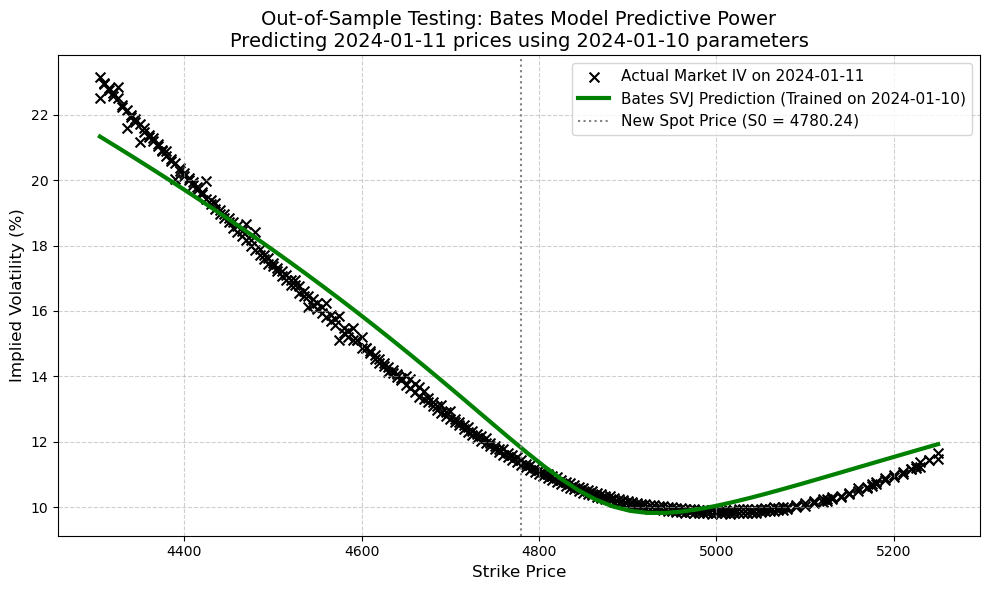

In [4]:
plt.figure(figsize=(10, 6))

# Plot the NEW Market Data for Day 2
plt.scatter(oos_valid_strikes, oos_target_ivs * 100, color='black', label=f'Actual Market IV on {OOS_DATE}', marker='x', s=50)

# Plot the Model's PREDICTION based on Day 1's training
plt.plot(smooth_strikes, oos_predicted_ivs, color='green', linewidth=3, label=f'Bates SVJ Prediction (Trained on {IN_SAMPLE_DATE})')

# Formatting
plt.axvline(oos_S0, color='gray', linestyle=':', label=f'New Spot Price (S0 = {oos_S0})')
plt.title(f"Out-of-Sample Testing: Bates Model Predictive Power\nPredicting {OOS_DATE} prices using {IN_SAMPLE_DATE} parameters", fontsize=14)
plt.xlabel("Strike Price", fontsize=12)
plt.ylabel("Implied Volatility (%)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
